# Diffusion Equation with Degradation and Production Terms

Here, the basic diffusion equation describing the dynamics of the diffusing particles with concentration $ c(x, t) $ is extended to include constant particle production and degradation terms, which are assumed Biology Physics. Then the diffusion equation is given by:

$$ \partial_t c(x, t) = D \partial_x^2 c(x, t) - \beta c(x, t) + \alpha \chi_{w}(x) $$

where:
- $ D $ is the diffusion coefficient,
- $ \beta $ is the degradation rate,
- $ \alpha $ is the constant production rate, in the particles production region.
- $ \chi_w(x) $ the characteristic shape function  of the particles production region. 
Here, let's assume that particles can be produced in the region centered at $ x = 0 $ with width $ w $

$$ 
    \chi_w(x) = 
        \begin{cases}
            1/w, &\quad x \in [-w/2, w/2] \\
            0, &\quad  x \not\in [-w/2, w/2]
        \end{cases} 
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
D     = 1.0  # Diffusion coefficient
beta  = 1.0  # Degradation rate
alpha = 1.0  # Production rate

w     = 2.0  # width of production region   

In [3]:
# parameters for Euler scheme

tmax = 2    # time till what to calculate solution
Lmax = 1e2  # system size, boundaries are far away ~ infinity

dt   = 1e-3 # time step
dx   = 1e-1 # spatial step

In [4]:
# arrays for space and time coordinates

x   = np.linspace(-Lmax, Lmax, 2*int(Lmax/dx)+1)
ndx = len(x)

t   = np.linspace(0, tmax, int(tmax/dt)+1)
ndt = len(t)

**Stability of numerical scheme**

To ensure numerical stability, the Euler scheme must satisfy the Courant–Friedrichs–Lewy (CFL) condition:

$$ D \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2} \quad. $$

This condition ensures that the time step is sufficiently small relative to the spatial step size and the diffusion coefficient. 

In [5]:
if D*dt/dx**2 < 0.5:
    print(f'the Courant condition is fullfilled, D*dt/dx**2 = {np.round(D*dt/dx**2, 2)}')
else:
    print(f'the Courant condition is NOT fullfilled, please, revise parameters for Euler scheme')
    print(f'D*dt/dx**2 = {np.round(D*dt/dx**2, 2)}')

the Courant condition is fullfilled, D*dt/dx**2 = 0.1


In [6]:
def numerical_laplacian(c, dx):
    """
    Numerical lapplacian for the concentration array.
    Parameters:
    c  : np.array - concentration array
    dx : float   - spatial discretization size
    Returns:
    np.array
    """
    c_iminus  = np.roll(c, 1)
    c_iplus   = np.roll(c, -1)
    laplacian = (c_iplus - 2*c + c_iminus)/dx**2
    return laplacian

**Let's start from zero concentration profile**

In [7]:
# list for the spatial profiles of concentration c as function of time
ct = []

# inital conditions: concentration N/dx at x = 0
c0 = np.zeros_like(x)
ct.append(c0)

In [8]:
def chi(x, w):
    """
    Shape function of particles production region.
    Parameters:
    x  : np.array - spatial coordinates
    w  : float   - size of production region centered at x = 0
    Returns:
    np.array
    """
    return (x <= w/2) * (x >= -w/2) * 1/w

In [9]:
from tqdm import tqdm # library to visualize the progress status of a python loop

# loop through time 
for n in tqdm( range(1, ndt) ):
    c_n = ct[-1]   
    c_nplus = c_n + (D * numerical_laplacian(c_n, dx) - beta * c_n + alpha * chi(x, w)) * dt
    ct.append(c_nplus)

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 10127.46it/s]


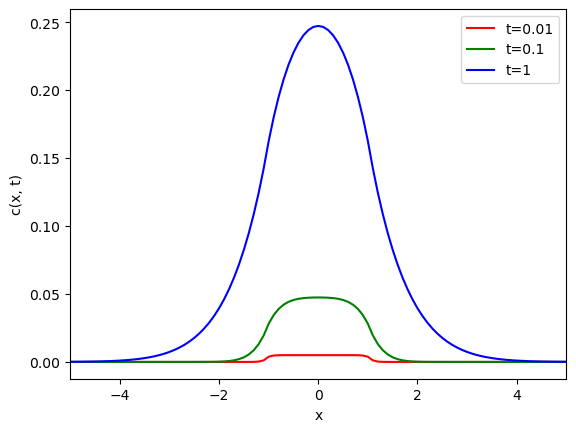

In [10]:
ax = plt.subplot()

colors = ['red', 'green', 'blue']

# plot a few time point
i = 0
for t in [0.01, 0.1, 1]:
    ax.plot(x, ct[int(t/dt)], color=colors[i], label=f't={t}')
    i = i + 1


plt.xlabel('x')
plt.ylabel('c(x, t)')
plt.xlim(-5, 5)
plt.legend()
plt.show()

# Steady state

For simplicity, the diffusion equation with degradation and production terms is always solved numerically in this repository, except in `diffusion_equation/1_solving_diffusion_equation.ipynb`.

However, it is often useful to find analytically the *steady state* profile, which occurs when the concentration profile no longer changes with time, i.e., $ \partial_t c = 0 $. Under this condition, the diffusion equation simplifies to an ordinary differential equation (ODE):

$$ D \partial_x^2 c - \beta c + \alpha \chi_w(x) = 0 \quad. $$

This equation can be solved using known Green's functions for the $ D \partial_x^2 - \beta $ operator 
$G(x, s) = \frac{1}{2\sqrt{D \beta}} \exp{ \left(-\frac{|s-x|}{\lambda} \right) }$, where $\lambda = \sqrt{\frac{D}{\beta}}$, 
by its convolution with the production term $\alpha \chi_w(x)$

$$ c_{\text{steady}} = \alpha \ ( G \ast \chi_w )(x) \quad. $$

In [11]:
def G(x, D, beta):
    """
    Green's function of operator D d^2 - beta
    Parameters:
    x   :  np.array - spatial coordinates
    D   :  float - diffusion coefficient 
    beta:  float - degradation rate
    Returns:
    np.array
    """
    lam = np.sqrt(D/beta)
    return np.exp(-np.abs(x)/lam)/np.sqrt(D*beta)/2

In [12]:
def steady(x, D, beta, alpha, w, dx):
    """
    Steady state of diffusion equation found as the convolution of its operator Green's function and production term.
    Parameters:
    x    :  np.array - spatial coordinates
    D    :  float - diffusion coefficient 
    beta :  float - degradation rate
    alpha:  float - production rate
    w    :  float - production region width
    dx   : float   - spatial discretization size
    Returns:
    np.array
    """
    return np.convolve(G(x, D, beta), alpha * chi(x, w), mode='same') * dx

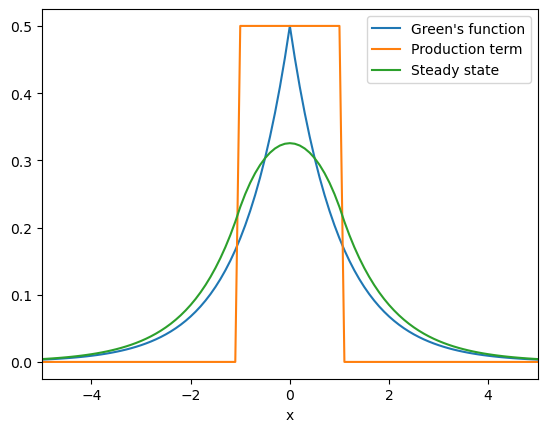

In [13]:
plt.plot( x, G(x, D, beta), label='Green\'s function')
plt.plot( x, alpha * chi(x, w), label='Production term')

plt.plot( x, steady(x, D, beta, alpha, w, dx), label='Steady state')

plt.xlabel('x')
plt.xlim(-5, 5)
plt.legend()
plt.show()

# Diffusion dynamics relaxes to steady

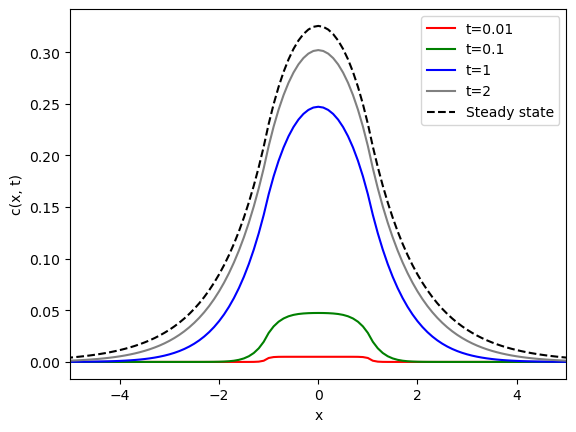

In [14]:
ax = plt.subplot()

colors = ['red', 'green', 'blue', 'gray']

# plot a few time point
i = 0
for t in [0.01, 0.1, 1, 2]:
    ax.plot(x, ct[int(t/dt)], color=colors[i], label=f't={t}')
    i = i + 1
    
plt.plot( x, steady(x, D, beta, alpha, w, dx), '--', color='black', label='Steady state')

plt.xlabel('x')
plt.ylabel('c(x, t)')
plt.xlim(-5, 5)
plt.legend()
plt.show()